# ============================================
# Semantic Analysis of Tourist Reviews
# Sentiment Classification (Weak Supervision) + Topic Modeling
# ============================================
### This notebook-style script is designed for Google Colab or Jupyter.
### Dataset: Tourist Review.csv (with column: review, location). Data will be loaded from an ONLINE SOURCE (GitHub raw link).

This project explores tourist reviews using Natural Language Processing (NLP).
Goals:
- Automatically assign sentiment labels using a pretrained model (VADER)
- Train classical ML classifiers on generated labels
- Perform topic modeling to discover common themes
- Analyze language patterns in positive and negative reviews

# ============================================
# 1. INSTALL & IMPORT LIBRARIES
# ============================================

In [1]:
!pip install nltk scikit-learn wordcloud
!pip install transformers

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter

from transformers import pipeline

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# ============================================
# 2. LOAD DATASET FROM GITHUB
# ============================================
### Dataset is stored inside GitHub repository and loaded via RAW link

In [2]:
DATA_URL = "https://raw.githubusercontent.com/MEGMON19/tourist-review-nlp/refs/heads/main/Tourist%20Review.csv"

df = pd.read_csv(DATA_URL)
print(df.head())
print(df.columns)

   ID     location  total review  \
0   1  Syambhunath    46 reviews   
1   2  Syambhunath   132 reviews   
2   3  Syambhunath   298 reviews   
3   4  Syambhunath   247 reviews   
4   5  Syambhunath    69 reviews   

                                              review  
0  It is at the top of valleys mountain.  Best pl...  
1  This place has a significant importance in Bud...  
2  Visited this from the other side on a rainy ev...  
3  A beautiful temple situated in the capital wit...  
4  great, beautiful, historic & religious place.....  
Index(['ID', 'location', 'total review', 'review'], dtype='object')


### Basic Exploration

In [3]:
print("Number of rows:", len(df))
print(df['location'].value_counts().head())

Number of rows: 7271
location
Pokhara                    936
Lumbini                    935
Pasupatinath Temple        930
Syambhunath                930
Bhaktapur Durbar Square    930
Name: count, dtype: int64


# ============================================
# 3. TEXT CLEANING
# ============================================

In [4]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [5]:
df['clean_text'] = df['review'].apply(clean_text)

# ============================================
# 4. AUTO-LABEL SENTIMENT WITH VADER
# ============================================
Sentiment labels are generated automatically using a pretrained model (VADER). This approach is known as weak supervision.


In [6]:
sia = SentimentIntensityAnalyzer()

In [7]:
scores = df['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [8]:
def vader_to_label(score):
  if score >= 0.05:
    return "positive"
  elif score <= -0.05:
    return "negative"
  else:
    return "neutral"

In [9]:
df['sentiment'] = scores.apply(vader_to_label)
print(df['sentiment'].value_counts())

sentiment
positive    5663
neutral     1336
negative     272
Name: count, dtype: int64


The dataset is highly imbalanced, with a strong dominance of positive reviews. This reflects a common real-world phenomenon where users are more likely to share positive travel experiences than negative ones. However, class imbalance makes classification of minority classes more challenging.

# ============================================
# 5. SPLIT DATA
# ============================================

In [10]:
X = df['clean_text']
y = df['sentiment']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=42
)

# ============================================
# 6. TF-IDF Vectorization
# ============================================

In [12]:
vectorizer = TfidfVectorizer(
  max_features=15000,
  stop_words='english',
  ngram_range=(1,2)
)

In [13]:
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# ============================================
# 7. Baseline Model - LOGISTIC REGRESSION
# ============================================

In [14]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

In [15]:
pred_log = log_model.predict(X_test_vec)
print("Logistic Regression Results")
print(classification_report(y_test, pred_log))

Logistic Regression Results
              precision    recall  f1-score   support

    negative       1.00      0.04      0.08        51
     neutral       0.85      0.44      0.58       261
    positive       0.86      0.99      0.92      1143

    accuracy                           0.86      1455
   macro avg       0.90      0.49      0.52      1455
weighted avg       0.86      0.86      0.83      1455



The baseline Logistic Regression model performs well for positive reviews but struggles with minority classes, especially negative sentiment. This behavior is caused by strong class imbalance.

# ============================================
# 8. Support Vector Machine SVM MODEL
# ============================================

In [16]:
svm_model = LinearSVC()
svm_model.fit(X_train_vec, y_train)

LinearSVC()

In [17]:
pred_svm = svm_model.predict(X_test_vec)
print("SVM Results")
print(classification_report(y_test, pred_svm))

SVM Results
              precision    recall  f1-score   support

    negative       0.69      0.22      0.33        51
     neutral       0.86      0.71      0.78       261
    positive       0.92      0.98      0.95      1143

    accuracy                           0.91      1455
   macro avg       0.82      0.64      0.69      1455
weighted avg       0.90      0.91      0.90      1455



Support Vector Machine significantly improves performance compared to Logistic Regression, especially for neutral and negative classes. This suggests that SVM is better suited for high-dimensional sparse TF-IDF features.

# ============================================
# 9. Hyperparameter Tuning - GRIDSEARCH
# ============================================

In [18]:
param_grid = {
  'C': [0.1, 1, 5]
}

In [19]:
grid = GridSearchCV(
  LogisticRegression(max_iter=1000),
  param_grid,
  cv=3,
  scoring='f1_macro'
)

In [20]:
grid.fit(X_train_vec, y_train)
print("Best parameters:", grid.best_params_)

Best parameters: {'C': 5}


In [21]:
gs_model = grid.best_estimator_
pred_gs = gs_model.predict(X_test_vec)
print("Tuned Logistic Regression")
print(classification_report(y_test, pred_gs))

Tuned Logistic Regression
              precision    recall  f1-score   support

    negative       0.75      0.18      0.29        51
     neutral       0.85      0.67      0.75       261
    positive       0.91      0.98      0.94      1143

    accuracy                           0.90      1455
   macro avg       0.84      0.61      0.66      1455
weighted avg       0.89      0.90      0.89      1455



Hyperparameter tuning improves the Logistic Regression model substantially. However, SVM still achieves the best overall balance between precision and recall.

## Model Comparison

The performance of evaluated models is summarized below:

| Model | Accuracy | Macro F1-score |
|-----|----------|----------------|
| Logistic Regression (baseline) | 0.86 | 0.52 |
| Tuned Logistic Regression | 0.90 | 0.66 |
| Support Vector Machine (SVM) | 0.91 | 0.69 |

SVM achieved the highest accuracy and the best balance between precision and recall across all classes. Therefore, SVM was selected as the final model for further analysis.


## **SVM achieved the highest accuracy and the best balance between precision and recall across all classes. Therefore, SVM was selected as the final model for further analysis.**

In [22]:
final_model = svm_model


# ============================================
# 10. Transformer-based Sentiment Analysis (BERT)
# ============================================

To verify the consistency of classical machine learning results, a pretrained transformer-based sentiment model (BERT) was tested on sample reviews. Transformer models leverage contextual word representations and often achieve strong performance on sentiment analysis tasks.

The BERT predictions were largely consistent with the labels produced by the classical models, especially for clearly positive reviews.


In [23]:
bert_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f.
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [24]:
samples = [
    "The place was absolutely wonderful and peaceful",
    "The area was dirty and poorly maintained",
    "It is a famous tourist destination"
]

In [25]:
for s in samples:
    print(s, "->", bert_pipeline(s))

The place was absolutely wonderful and peaceful -> [{'label': 'POSITIVE', 'score': 0.9998874664306641}]
The area was dirty and poorly maintained -> [{'label': 'NEGATIVE', 'score': 0.9997653365135193}]
It is a famous tourist destination -> [{'label': 'POSITIVE', 'score': 0.9997461438179016}]


The BERT model correctly classified clearly positive and negative examples with very high confidence. This qualitative evaluation shows strong agreement between transformer-based predictions and the labels produced by classical machine learning models, providing additional validation of the overall approach.


# ============================================
# 11. Confusion Matrix
# ============================================

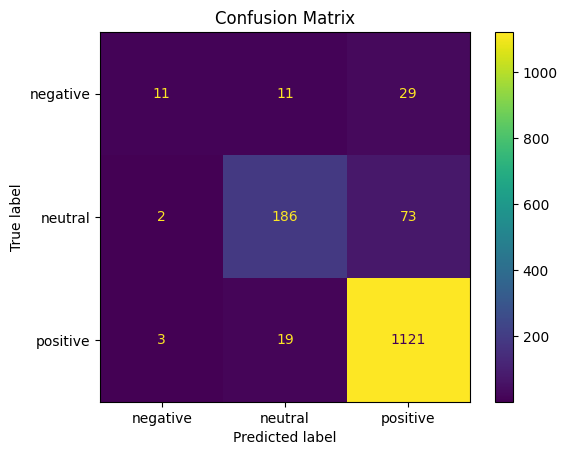

In [26]:
ConfusionMatrixDisplay.from_estimator(
  final_model,
  X_test_vec,
  y_test
)
plt.title("Confusion Matrix")
plt.show()

The confusion matrix shows that misclassifications mainly occur between neutral and positive classes, while negative reviews are often misclassified as positive. This reflects the linguistic similarity between neutral and positive opinions and scarcity of negative examples.

# ============================================
# 12. Most Important Words
# ============================================

In [27]:
feature_names = vectorizer.get_feature_names_out()

In [28]:
for i, label in enumerate(final_model.classes_):
  top = np.argsort(final_model.coef_[i])[-10:]
  print("Top words for", label)
  print([feature_names[j] for j in top])

Top words for negative
['death', 'explain birth', 'horrible', 'stall', 'sad', 'unfortunately', 'maintenance', 'lies', 'dirty', 'bad']
Top words for neutral
['land', 'amizing', 'nan', 'traditional architecture', 'holy hindu', 'google simply', 'tourist area', 'good ancient', 'google rotate', 'annapurna base']
Top words for positive
['love', 'awesome', 'peaceful', 'like', 'nice', 'good', 'amazing', 'peace', 'beautiful', 'best']


## The most important words extracted by the classifier are highly interpretable and align well with human intuition, confirming that the model learns meaningful semantic patterns.

# ============================================
# 13. Topic Modeling (LDA)
# ============================================

In [29]:
lda_vectorizer = TfidfVectorizer(
  max_features=5000,
  stop_words='english'
)

In [30]:
X_lda = lda_vectorizer.fit_transform(df['clean_text'])

In [31]:
lda = LatentDirichletAllocation(
  n_components=5,
  random_state=42
)

In [32]:
lda.fit(X_lda)

LatentDirichletAllocation(n_components=5, random_state=42)

In [33]:
lda_features = lda_vectorizer.get_feature_names_out()

In [34]:
for idx, topic in enumerate(lda.components_):
  print(f"Topic {idx+1}:")
  print([lda_features[i] for i in topic.argsort()[-10:]])

Topic 1:
['camp', 'lake', 'langtang', 'national', 'park', 'bardiya', 'visit', 'cool', 'place', 'beautiful']
Topic 2:
['born', 'birthplace', 'gautam', 'amazing', 'peace', 'temple', 'birth', 'lord', 'place', 'buddha']
Topic 3:
['nepal', 'love', 'time', 'durbar', 'square', 'beautiful', 'visit', 'bhaktapur', 'best', 'place']
Topic 4:
['site', 'good', 'nepal', 'heritage', 'world', 'visit', 'kathmandu', 'place', 'temple', 'nan']
Topic 5:
['good', 'best', 'safari', 'nature', 'beautiful', 'visit', 'park', 'awesome', 'place', 'nice']


## Topic modeling reveals several coherent themes related to nature tourism, religious sites, heritage cities, and national parks, confirming that the dataset captures diverse types of tourist experiences.

# ============================================
# 14. Simple Location-Based Analysis
# ============================================

In [35]:
location_sentiment = df.groupby(['location','sentiment']).size().unstack().fillna(0)
print(location_sentiment.head())

sentiment                negative  neutral  positive
location                                            
Annapurna Base Camp            10       22       100
Bardiya National Park          15      159       454
Bhaktapur Durbar Square        51      133       746
Chitwan National Park          38      101       791
Everest Base Camp Trek          7       30        83


Location-based analysis shows that most popular destinations receive predominantly positive sentiment, but some locations exhibit higher proportions of neutral or negative opinions, which could indicate areas for improvement.

# ============================================
# 15. LIMITATIONS
# ============================================

- Dataset is highly imbalanced.
- Sentiment labels are automatically generated and may contain noise.
- Only English language reviews were considered.

# ============================================
# 16. CONCLUSIONS
# ============================================

This project demonstrated how Natural Language Processing techniques can be applied to analyze tourist reviews.

First, Sentiment labels in this project were generated automatically using a pretrained sentiment analyzer (VADER). Such weak supervision introduces label noise, as automatically generated labels may contain errors or biases. These imperfections can propagate into supervised models trained on this data. Therefore, results should be interpreted with caution, and manual annotation would be required for high-stakes applications.
 Classical machine learning models were then trained using TF-IDF features.

Among the evaluated models, Support Vector Machine achieved the best overall performance with 91% accuracy and the highest macro F1-score. Hyperparameter tuning improved Logistic Regression performance, but it remained slightly inferior to SVM.

Feature importance analysis showed that the models learned meaningful semantic patterns, with positive words such as *beautiful*, *amazing*, and *peaceful*, and negative words such as *dirty*, *bad*, and *unfortunately*.

Topic modeling revealed coherent themes related to nature tourism, religious sites, heritage cities, and national parks, indicating that the dataset captures diverse tourist experiences.

Location-based analysis showed that most destinations receive predominantly positive reviews, although some locations exhibit higher proportions of neutral and negative opinions.

Limitations of this study include class imbalance and reliance on automatically generated sentiment labels. Future work could include manual annotation, class balancing techniques, and fine-tuning transformer-based models.

Overall, the results confirm that NLP methods can effectively extract insights from large collections of tourist reviews.

Additionally, a pretrained BERT model was used for qualitative validation and produced predictions consistent with the classical models, further supporting the reliability of the obtained results.

